In [1]:
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm, trange
import sys
import matplotlib.pyplot as plt

In [2]:
# variaveis
L = 100 # lado do lattice
n_lagartos = L**2 # lagartos que cabem no lattice
estrategias = ['O', 'Y', 'B'] # estratégias possíveis
a = 2 # ganho em fitness ao vencer
b = 1/a # ganho em fitness ao perder
matriz_payoff = np.array([[1, b, a],
                          [a, 1, b],
                          [b, a, 1]])
index_map = {'O': 0, 'Y': 1, 'B': 2}
n_geracoes = 100
n_pop = 100 # número de populações independentes
tipo = "homogenea" # tipo de vizinhança: "homogenea", "I", "II" ou "adaptativa"
prob_mutacao = None # probabilidade de mutação a cada geração
threshold_O = 0.9 # threshold para a proporção de O na vizinhança adaptativa
if tipo == "adaptativa":
    output_dir = "C:/Unicamp/mestrado/simulacoes/RPS-python/RPS-POO/outputs/" + tipo + "/" + f"_threshold_{threshold_O}/"
elif tipo == "homogenea":
    output_dir = "C:/Unicamp/mestrado/simulacoes/RPS-python/RPS-POO/outputs/" + tipo + "/" + f"Moore_4/"
else:
    output_dir = "C:/Unicamp/mestrado/simulacoes/RPS-python/RPS-POO/outputs/" + tipo + "/"

os.makedirs(output_dir, exist_ok=True)

In [3]:
class Lagarto:
  def __init__(self, i, j, estrategia, fitness, coord_vizinhos, estrategia_vizinhos, coord_vizinhanca_extendida, estrategia_vizinhanca_extendida, tipo_vizinhanca, t, n_vizinhos):
    self.i = i # linha
    self.j = j # coluna
    self.estrategia = estrategia
    self.fitness = 0 # inicia com 0 de fitness
    self.coord_vizinhos = [] # lista vazia para adicionar as coordenadas dos vizinhos
    self.estrategia_vizinhos = [] # lista vazia para adicionar as estratégias dos vizinhos
    self.coord_vizinhanca_extendida = []
    self.estrategia_vizinhanca_extendida = []
    self.tipo_vizinhanca = tipo # tipo de vizinhança "homogenea", "I" ou "II"
    self.t = 0 # determina a geracao do lagarto
    self.n_vizinhos = 0 # número de vizinhos

  def calcular_coord_vizinhos(self, L, matriz_posicao, threshold_O): # obtém as coordenadas dos vizinhos

      if self.tipo_vizinhanca == "homogenea":
        radius_map = {'B': 4, 'O': 4, 'Y': 4} # raio da vizinhança homogenea: todos com vizinhança de Moore (8 vizinhos)
        r = radius_map.get(self.estrategia, 1) # verifica qual a estrategia do lagarto pra saber qual vizinhança usar

        lista_vizinhos = []
        for x in range(-r, r + 1):
            for y in range(-r, r + 1):
                if x == 0 and y == 0: # não inclui o próprio lagarto na lista vizinhos
                    continue
                ni = (self.i + x) % L # fronteiras periódicas (obtém a linha)
                nj = (self.j + y) % L # obtém a coluna
                lista_vizinhos.append((ni, nj)) # retorna duplex (linha, coluna)
        self.coord_vizinhos = lista_vizinhos

      elif self.tipo_vizinhanca == "I":
        radius_map = {'B': 1, 'O': 2, 'Y': 3} # raio da vizinhança Y > O > B
        r = radius_map.get(self.estrategia, 1) # verifica qual a estrategia do lagarto pra saber qual vizinhança usar

        lista_vizinhos = []
        for x in range(-r, r + 1):
            for y in range(-r, r + 1):
                if x == 0 and y == 0: 
                    continue
                ni = (self.i + x) % L 
                nj = (self.j + y) % L 
                lista_vizinhos.append((ni, nj)) 
        self.coord_vizinhos = lista_vizinhos

      elif self.tipo_vizinhanca == "II":
        radius_map = {'B': 2, 'O': 3, 'Y': 2} # raio da vizinhança O > Y = B
        r = radius_map.get(self.estrategia, 1) # verifica qual a estrategia do lagarto pra saber qual vizinhança usar

        lista_vizinhos = []
        for x in range(-r, r + 1):
            for y in range(-r, r + 1):
                if x == 0 and y == 0: 
                    continue
                ni = (self.i + x) % L 
                nj = (self.j + y) % L
                lista_vizinhos.append((ni, nj)) 
        self.coord_vizinhos = lista_vizinhos
      
      elif self.tipo_vizinhanca == "adaptativa":
        radius_map = {'B': 2, 'O': 3, 'Y': 2} # raio da vizinhança adaptativa (Y pode ser igual a B ou O, dependendo do threshold)
        r = radius_map.get(self.estrategia, 1) # verifica qual a estrategia do lagarto pra saber qual vizinhança usar 

        lista_vizinhos = []
        if self.estrategia == 'O' or self.estrategia == "B" : # se for O ou B, usa vizinhança normal
          for x in range(-r, r + 1):
              for y in range(-r, r + 1):
                  if x == 0 and y == 0: 
                    continue 
                  ni = (self.i + x) % L 
                  nj = (self.j + y) % L 
                  lista_vizinhos.append((ni, nj)) 
        
        elif self.estrategia == 'Y': # se for Y, usa vizinhança adaptativa
            for x in range(-r, r + 1): # inicia com r = 2
              for y in range(-r, r + 1):
                  if x == 0 and y == 0: 
                    continue 
                  ni = (self.i + x) % L 
                  nj = (self.j + y) % L 
                  lista_vizinhos.append((ni, nj)) 
            estrategia_vizinhos = [matriz_posicao[ni, nj] for ni, nj in lista_vizinhos] # verifica quem são os vizinhos
            if sum(e == 'O' for e in estrategia_vizinhos) < threshold_O * len(estrategia_vizinhos): # se a proporção de O na vizinhança for menor que threshold, usa vizinhança maior
               r = 3 # vizinhança maior
               lista_vizinhos = []
               for x in range(-r, r + 1):
                 for y in range(-r, r + 1):
                   if x == 0 and y == 0: 
                    continue 
                   ni = (self.i + x) % L 
                   nj = (self.j + y) % L 
                   lista_vizinhos.append((ni, nj)) 

        self.coord_vizinhos = lista_vizinhos
    
  def obter_estrategia_vizinhos(self, matriz_posicao):
      self.estrategia_vizinhos = [matriz_posicao[ni, nj] for ni, nj in self.coord_vizinhos] # dadas as coordenadas, obtém a estratégia do lagarto que ocupa aquela posição

  def mutacao(self, prob_mutacao): # função de mutação
    if np.random.rand() < prob_mutacao: # sorteia um valor entre 0 e 1, se for menor que a probabilidade de mutação, o lagarto muda de estratégia
        estrategias_possiveis = [e for e in estrategias if e != self.estrategia] # obtém as estratégias possíveis, exceto a atual
        self.estrategia = np.random.choice(estrategias_possiveis) # escolhe uma nova estratégia aleatoriamente para mutar

  def calcular_n_vizinhos(self): # calcula o número de vizinhos
      self.n_vizinhos = len(self.estrategia_vizinhos) + len(self.estrategia_vizinhanca_extendida)

def calcular_media_vizinhos(lagartos, estrategias):
    medias = []
    for e in estrategias:
        viz = [lag.n_vizinhos for lag in lagartos if lag.estrategia == e]
        medias.append(np.mean(viz) if len(viz) > 0 else 0)
    return medias # retorna a média de vizinhos para cada estratégia

def ajustar_vizinhos_reciprocos(lagartos): # garante que se A é vizinho de B, B também é vizinho de A, pois as interações são recíprocas
    mapa = {(l.i, l.j): l for l in lagartos} # dicionário pra acessar lagartos pela posição

    for l in lagartos:
        for (ni, nj) in l.coord_vizinhos: # vai em todos os vizinhos do lagarto atual (l)
            vizinho = mapa[(ni, nj)]
            # se o lagarto atual (l) não estiver na lista de vizinhos do vizinho, adiciona em vizinhanca_extendida
            if (l.i, l.j) not in vizinho.coord_vizinhos:
                vizinho.estrategia_vizinhanca_extendida.append(str(l.estrategia))
                vizinho.coord_vizinhanca_extendida.append((l.i, l.j))

In [4]:
def criar_lagartos(n_lagartos, L, estrategias, tipo): # define as posições e estratégias dos lagartos no t = 0
  lista_lagartos = []

  # posições iniciais aleatórias
  all_positions = [(i, j) for i in range(L) for j in range(L)] # forma todas as posições possíveis em um lattice
  unique_positions_indices = np.random.choice(len(all_positions), n_lagartos, replace=False) # determina o índice de onde vai ficar cada posição
  unique_positions = [all_positions[i] for i in unique_positions_indices] # basicamente, ele embaralhou as posições

  for g in range(n_lagartos):
    i, j = unique_positions[g] # posição na matriz
    estrategia = np.random.choice(estrategias) # sorteia a estrategia
    lista_lagartos.append(Lagarto(i, j, estrategia, 0, [], [], [], [], tipo, 0, 0)) # cria o lagarto
  return lista_lagartos

def calcular_fitness(lagarto, matriz_payoff, index_map, matriz_posicao): # função para calcular o fitness do lagarto
    fitness_total = 0 # inicia no 0
    
    todos_vizinhos = set(lagarto.coord_vizinhos + lagarto.coord_vizinhanca_extendida) # junta todos os vizinhos (normais e estendidos) em um set para evitar que um vizinho seja contado duas vezes
    for ni, nj in todos_vizinhos:
        vizinho_estrat = matriz_posicao[ni, nj] # pega a estratégia do vizinho dadas as suas coordenadas
        if vizinho_estrat is not None:
            fitness_total += matriz_payoff[index_map[lagarto.estrategia], index_map[vizinho_estrat]] # calcula o payoff do lagarto contra o vizinho de acordo com a matriz de payoff e soma ao fitness total
    lagarto.fitness = fitness_total
    return fitness_total

calcular_freq = lambda mat: np.array([np.sum(mat == s) / (L ** 2) for s in ['O', 'Y', 'B']]) # calcula a frequência de cada estratégia no lattice na ordem O, Y, B

In [5]:
def atualizar_lagartos(lagartos): # função que atualiza as estratégias dos lagartos com base no fitness dos vizinhos
    novas_estrategias = {} # Dicionário para armazenar as novas estratégias

    mapa = {(l.i, l.j): l for l in lagartos} # dicionário para acessar lagartos pela posição

    for lagarto in lagartos:
        melhor_estrategia = lagarto.estrategia # inicia com a própria estratégia
        maior_fitness = lagarto.fitness # verifica o fitness do próprio lagarto

        # verifica o fitness dos vizinhos normais
        for (ni, nj) in lagarto.coord_vizinhos:
            vizinho = mapa[(ni, nj)] # usa o dicionário para achar o vizinho
            if vizinho.fitness > maior_fitness: # se o fitness do vizinho for maior que o maior fitness atual
                maior_fitness = vizinho.fitness # atualiza o maior fitness
                melhor_estrategia = vizinho.estrategia # atualiza a melhor estratégia
                # se houver empate de fitness ou for menor, mantém a estratégia atual (não muda)

        # verifica o fitness dos vizinhos extendidos
        for (ni, nj) in lagarto.coord_vizinhanca_extendida:
            vizinho = mapa[(ni, nj)] 
            if vizinho.fitness > maior_fitness:
                maior_fitness = vizinho.fitness
                melhor_estrategia = vizinho.estrategia

        novas_estrategias[(lagarto.i, lagarto.j)] = melhor_estrategia # armazena a nova estratégia no dicionário

    # atualiza as estratégias de todos os lagartos simultaneamente
    for lagarto in lagartos:
        lagarto.estrategia = novas_estrategias[(lagarto.i, lagarto.j)] # evita que a atualização de um lagarto influencie outro na mesma geração (sem sobreposição de geração)

    
    return lagartos

In [ ]:
from tqdm.notebook import tqdm

# iniciando a simulação
def simulacao(n_geracoes, L, n_lagartos, estrategias, matriz_payoff, index_map, n_pop, tipo, threshold_O, prob_mutacao = None, seed = None):
    matriz_frequencias = np.full((n_geracoes + 1, n_pop, len(estrategias)), None) # cria uma matriz em que as linhas são as gerações, e as colunas são as populações
    # armazena as frequências das três estratégias
    matriz_n_vizinhos = np.full((n_geracoes + 1, n_pop, len(estrategias)), None)  # cria uma matriz para armazenar vizinhos


    for pop in tqdm(range(n_pop), desc = "Populações", position=0, leave = True): # loop para cada população independente
      if seed is not None:
          np.random.seed(seed + pop) # coloca uma semente diferente pra cada pop, garantindo independência

      frequencias = [] # vai armazenar as frequências ao longo das gerações para essa população
      lista_lagartos = criar_lagartos(n_lagartos, L, estrategias, tipo) # cria os lagartos
      matriz_posicao = np.full((L, L), None) # cria uma matriz vazia com None
      for lagarto in lista_lagartos:
        matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia) # cria a matriz de posições de acordo com os lagartos

      frequencias.append(calcular_freq(matriz_posicao)) # calcula a frequência inicial

      for t in tqdm(range(1, n_geracoes + 1), desc="Gerações", position=1, leave=True): # loop para cada geração dentro da população
        # determinando os vizinhos
        for lagarto in lista_lagartos:
          lagarto.calcular_coord_vizinhos(L, matriz_posicao, threshold_O) # calcula as coordenadas dos vizinhos
          lagarto.obter_estrategia_vizinhos(matriz_posicao) # obtém as estratégias dos vizinhos

          lagarto.coord_vizinhanca_extendida = [] # zera a vizinhança estendida para recalcular
          lagarto.estrategia_vizinhanca_extendida = [] 

        ajustar_vizinhos_reciprocos(lista_lagartos) # ajusta as vizinhanças recíprocas

        for lagarto in lista_lagartos:
          lagarto.calcular_n_vizinhos() # calcula o número de vizinhos
        
        matriz_n_vizinhos[t, pop, :] = calcular_media_vizinhos(lista_lagartos, estrategias) # # calcula a média de vizinhos para cada estratégia e armazena na matriz de vizinhos

        # calculando o fitness
        for lagarto in lista_lagartos:
          calcular_fitness(lagarto, matriz_payoff, index_map, matriz_posicao) # calcula o fitness do lagarto de acordo com seus vizinhos e a matriz de fitness

        # criando a matriz de fitness
        matriz_fitness = np.full((L, L), None) # cria uma matriz vazia com None
        for lagarto in lista_lagartos:
          matriz_fitness[lagarto.i, lagarto.j] = float(lagarto.fitness) # coloca os fitness nas posições

        lista_lagartos = atualizar_lagartos(lista_lagartos) # atualiza as estratégias dos lagartos de acordo com o maior fitness dos vizinhos

        if prob_mutacao is not None:
          for lagarto in lista_lagartos:
            lagarto.mutacao(prob_mutacao) # aplica a mutação

        # atualiza a matriz de posição com as novas estratégias e com as mutações
        matriz_posicao = np.full((L, L), None)
        for lagarto in lista_lagartos:
          matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia)

        frequencias.append(calcular_freq(matriz_posicao)) # calcula a frequência dessa geração e armazena em frequencias

        for lagarto in lista_lagartos:
            lagarto.t += 1 # incrementa a geração do lagarto

      frequencias = np.array(frequencias)
      matriz_frequencias[:, pop, :] = frequencias

    return matriz_frequencias, matriz_n_vizinhos

freq, n_vizinhos = simulacao(n_geracoes, L, n_lagartos, estrategias, matriz_payoff, index_map, n_pop, tipo, threshold_O, prob_mutacao, seed = 1)

Populações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

Gerações:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# transforma freq em DataFrame formato tidy
linhas = []
for t in range(freq.shape[0]):             # gerações
    for pop in range(freq.shape[1]):       # populações
        for idx, strategy in enumerate(estrategias):  # estratégias
            linhas.append({
                "t": t, # coluna 1: geração
                "pop": pop, # coluna 2: população
                "estrategia": strategy, # coluna 3: estrategia
                "frequencia": freq[t, pop, idx] # coluna 4: frequência da estratégia naquela geração, naquela população
            })

df_long = pd.DataFrame(linhas)

# salvar como CSV
df_long.to_csv(os.path.join(output_dir, "frequencias_tipo" + tipo + ".csv"), index=False)

In [8]:
# salva a matriz de vizinhos como DataFrame formato tidy
linhas = []
n_vizinhos = np.array(n_vizinhos, dtype=float)  # converte para float para evitar problemas com None

for t in range(n_vizinhos.shape[0]):          # gerações
    for pop in range(n_vizinhos.shape[1]):    # populações
        for idx, strategy in enumerate(estrategias):  # estratégias
            linhas.append({
                "t": t,                        # geração
                "pop": pop,                    # população
                "estrategia": strategy,        # estratégia
                "n_vizinhos": n_vizinhos[t, pop, idx]  # média de vizinhos
            })

df_n_vizinhos = pd.DataFrame(linhas)

# salvar como CSV
df_n_vizinhos.to_csv(os.path.join(output_dir, f"n_vizinhos.csv"), index=False)

#print(df_n_vizinhos.head(10))


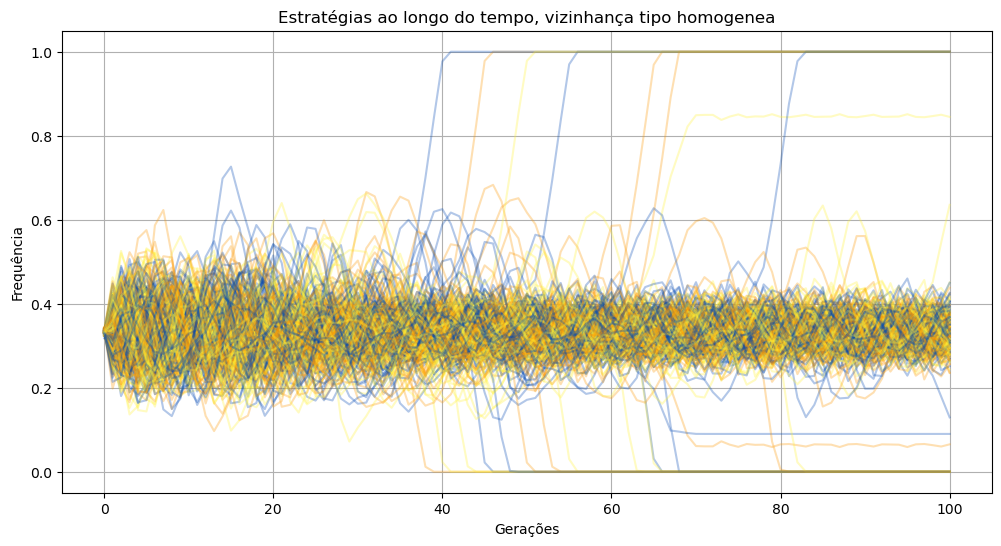

In [9]:
cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

plt.figure(figsize=(12, 6))

for pop in range(freq.shape[1]):  # para cada simulação
    for idx, strategy in enumerate(estrategias):
        plt.plot(
            range(freq.shape[0]),
            freq[:, pop, idx],
            label=f"{strategy} (sim {pop+1})",
            color=cores[strategy],
            alpha = 0.3
        )

plt.title("Estratégias ao longo do tempo, vizinhança tipo " + tipo)
plt.xlabel("Gerações")
plt.ylabel("Frequência")
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plot_freq_todos_tipo_" + tipo + ".png"), dpi = 300, bbox_inches='tight')
plt.show()

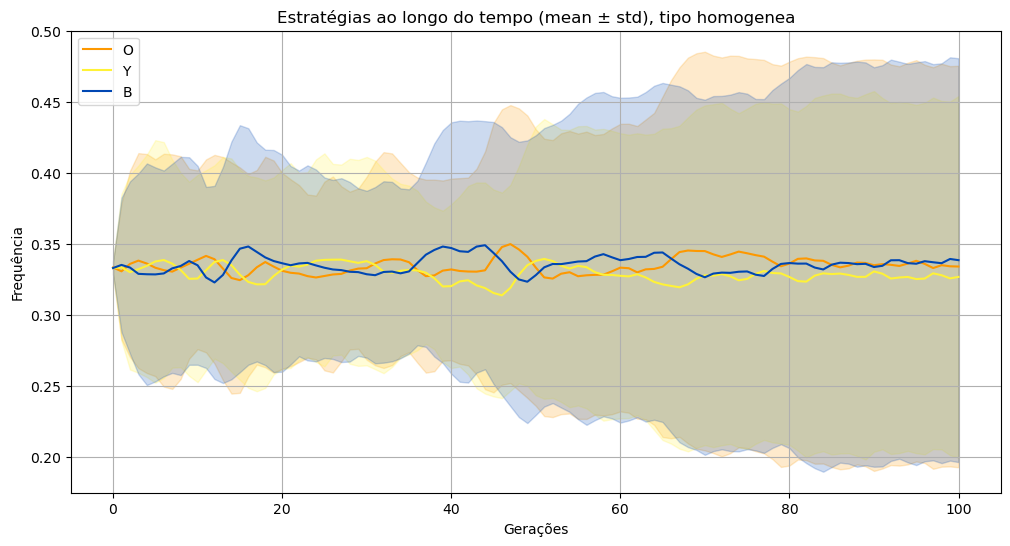

In [10]:
cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

plt.figure(figsize=(12, 6))

for idx, strategy in enumerate(estrategias):
    media = np.array(freq[:, :, idx], dtype=float).mean(axis=1)
    desvio = np.array(freq[:, :, idx], dtype=float).std(axis=1)


    plt.plot(range(freq.shape[0]), media, label=strategy, color=cores[strategy])
    plt.fill_between(range(freq.shape[0]), media-desvio, media+desvio,
                     color=cores[strategy], alpha=0.2)

plt.title("Estratégias ao longo do tempo (mean ± std), tipo " + tipo)
plt.xlabel("Gerações")
plt.ylabel("Frequência")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plot_freq_media_tipo_" + tipo + ".png"), dpi = 300, bbox_inches='tight')
plt.show()

In [11]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def simulacao_gif(n_geracoes, L, n_lagartos, estrategias, matriz_payoff, index_map, tipo, threshold_O, prob_mutacao, seed = None):

    matrizes_posicao_hist = [] # lista para armazenar as matrizes de posição de cada geração
    matrizes_fitness_hist = []

    if seed is not None:
        np.random.seed(seed) # coloca uma semente diferente pra cada pop

    # criando a matriz inicial
    lista_lagartos = criar_lagartos(n_lagartos, L, estrategias, tipo)
    matriz_posicao = np.full((L, L), None) # cria uma matriz vazia com None
    matriz_fitness = np.full((L, L), 0.0) # cria uma matriz vazia com 0

    for lagarto in lista_lagartos:
      matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia) # coloca os lagartos nas posições
    matrizes_posicao_hist.append(matriz_posicao.copy()) # junta as matrizes em uma lista
    matrizes_fitness_hist.append(matriz_fitness.copy())

    for t in trange(1, n_geracoes + 1, desc="Gerações", leave=False):
    # criando os vizinhos
      for lagarto in lista_lagartos:
        lagarto.calcular_coord_vizinhos(L, matriz_posicao, threshold_O)
        lagarto.obter_estrategia_vizinhos(matriz_posicao)

        lagarto.coord_vizinhanca_extendida = []
        lagarto.estrategia_vizinhanca_extendida = []

      ajustar_vizinhos_reciprocos(lista_lagartos)

      # calculando o fitness
      for lagarto in lista_lagartos:
        calcular_fitness(lagarto, matriz_payoff, index_map, matriz_posicao)

      # criando a matriz de fitness
      matriz_fitness = np.full((L, L), 0.0)
      for lagarto in lista_lagartos:
        matriz_fitness[lagarto.i, lagarto.j] = float(lagarto.fitness) # coloca os fitness nas posições
      #print(matriz_fitness)

      lista_lagartos = atualizar_lagartos(lista_lagartos)

      # atualiza a matriz de posição com as novas estratégias e com as mutações
      matriz_posicao = np.full((L, L), None)
      for lagarto in lista_lagartos:
        matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia)

      for lagarto in lista_lagartos:
            lagarto.t += 1

      matrizes_posicao_hist.append(matriz_posicao.copy()) # Append updated matrix position
      matrizes_fitness_hist.append(matriz_fitness.copy())

    return matrizes_posicao_hist, matrizes_fitness_hist # Return both frequencies and matrix history

matrizes_posicao_hist, matrizes_fitness_hist = simulacao_gif(n_geracoes, L, n_lagartos, estrategias, matriz_payoff, index_map, tipo, threshold_O, prob_mutacao, seed=1)

In [12]:
# gerando o GIF das posições

import matplotlib.colors as mcolors

cores_grid = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

def matriz_para_rgb(matriz):
    # Converte hex para RGB normalizado (0-1)
    return np.array([[mcolors.to_rgb(cores_grid.get(cell, "#FFFFFF")) for cell in row] for row in matriz])

# Crie a figura
fig, ax = plt.subplots(figsize=(6, 6))

def update(frame):
    ax.clear()
    ax.imshow(matriz_para_rgb(matrizes_posicao_hist[frame]))
    ax.set_title(f"Geração {frame}")
    ax.axis('off')

ani = animation.FuncAnimation(
    fig, update, frames=len(matrizes_posicao_hist), interval=100, repeat=False
)


# Salvar como GIF
ani.save(os.path.join(output_dir, f"simulacao_grid_tipo_{tipo}.gif"), writer='pillow', fps=10)
ani.save(os.path.join(output_dir, f"simulacao_grid_tipo_{tipo}.mp4"), writer='ffmpeg', fps=5)
plt.close()

In [13]:
# gerando o GIF dos fitness

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(matrizes_fitness_hist[0], cmap='viridis', vmin=0, vmax=np.max(matrizes_fitness_hist))
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Fitness')

def update_fitness(frame):
    im.set_data(matrizes_fitness_hist[frame])
    ax.set_title(f"Fitness - Geração {frame}")
    ax.axis('off')
    return [im]

ani = animation.FuncAnimation(
    fig, update_fitness, frames=len(matrizes_fitness_hist), interval=100, blit=False, repeat=False
)

ani.save(os.path.join(output_dir, f"simulacao_fitness_tipo_{tipo}.gif"), writer='pillow', fps=10)
ani.save(os.path.join(output_dir, f"simulacao_fitness_tipo_{tipo}.mp4"), writer='ffmpeg', fps=5)
plt.close()

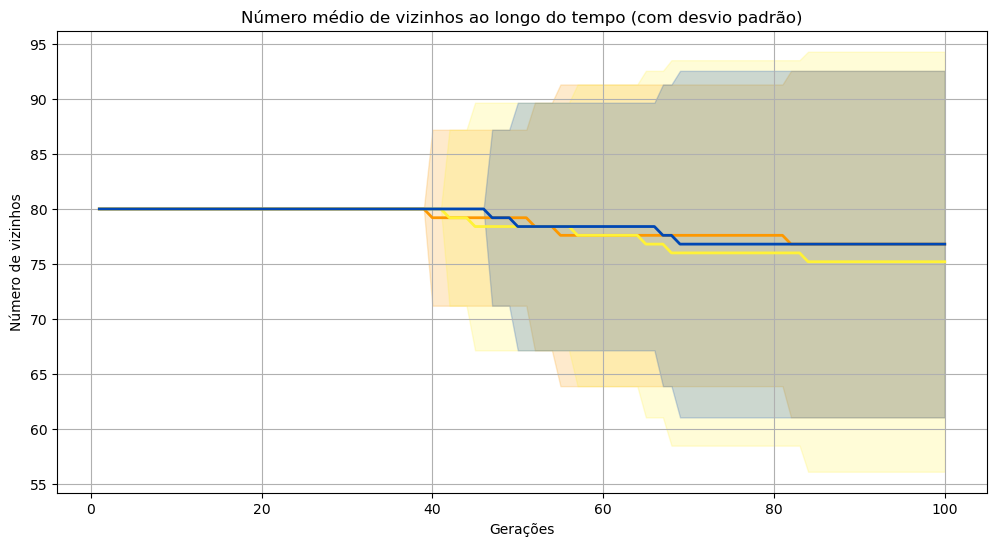

In [14]:
# agrupa por geração e estratégia -> calcula média e desvio entre populações
grouped = df_n_vizinhos.groupby(["t", "estrategia"])["n_vizinhos"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(12, 6))

for strategy in estrategias:
    dados = grouped[grouped["estrategia"] == strategy]
    
    # curva da média
    plt.plot(
        dados["t"], 
        dados["mean"], 
        label=strategy, 
        color=cores[strategy], 
        linewidth=2
    )
    
    # faixa do desvio padrão
    plt.fill_between(
        dados["t"], 
        dados["mean"] - dados["std"], 
        dados["mean"] + dados["std"], 
        color=cores[strategy], 
        alpha=0.2
    )

plt.title("Número médio de vizinhos ao longo do tempo (com desvio padrão)")
plt.xlabel("Gerações")
plt.ylabel("Número de vizinhos")
plt.grid(True)
#plt.legend()
plt.savefig(os.path.join(output_dir, "plot_n_vizinhos_media_std.png"), dpi=300, bbox_inches='tight')
plt.show()

In [15]:
#teste

#print(posicao_inicial_m)

#lagarto = lista_lagartos[5]
#print(lagarto.i)
#print(lagarto.j)
#print(lagarto.estrategia)
#print(lagarto.estrategia_vizinhos)
#print(len(lagarto.estrategia_vizinhos))
#print(lagarto.vizinhanca_extendida)
#print(lagarto.fitness)